<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/LondonBikeSharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

In [5]:
import seaborn as sns

In [2]:
data = pd.read_csv('/content/london_merged.csv')

In [3]:
data.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [ ]:
data.shape

(17414, 10)

Vemos que tenemos una cantidad bastante buena de muestras.

Las variables son:

"timestamp" - timestamp field for grouping the data

"cnt" - the count of a new bike shares

"t1" - real temperature in C

"t2" - temperature in C "feels like"

"hum" - humidity in percentage

"windspeed" - wind speed in km/h

"weathercode" - category of the weather

"isholiday" - boolean field - 1 holiday / 0 non holiday

"isweekend" - boolean field - 1 if the day is weekend

"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

"weathe_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [11]:
target = 'cnt'
features = [i for i in data.columns if i not in [target]]

print("Target:", target)
print("Variables de contexto:", features)

Target: cnt
Variables de contexto: ['timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']


In [13]:
data.isnull().values.sum()

0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


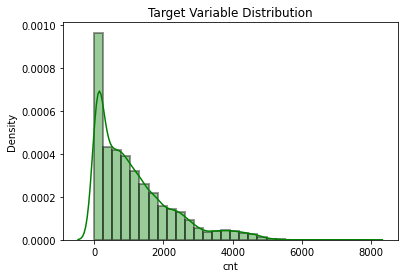

In [12]:
plt.figure()
sns.distplot(data[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution')
plt.show()

In [15]:
#convertir "timestamp" a formato datatime para poder separar la información en variables
data['timestamp'] = pd.to_datetime(data['timestamp'])


data["year"] = data['timestamp'].dt.year #años
data["month"] = data['timestamp'].dt.month #meses
data["day_of_month"] = data['timestamp'].dt.day #día del mes
data["day_of_week"] = data['timestamp'].dt.weekday #dia de la semana
data["hour"] = data['timestamp'].dt.hour #horas
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day_of_month,day_of_week,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,6,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,6,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,4,6,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,4,6,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,6,4


In [ ]:
#timestamp
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values

In [ ]:
data.shape[0]

17414

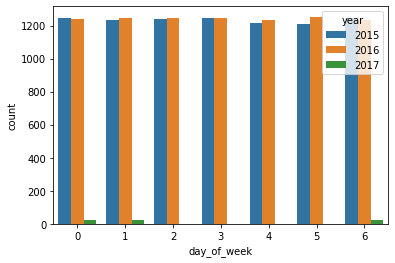

In [ ]:
sns.countplot(x="day_of_week", hue="year", data=data) 

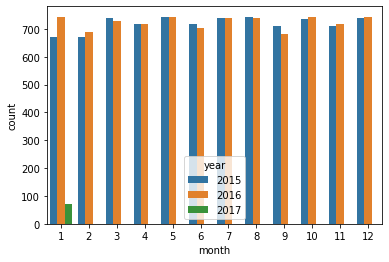

In [ ]:
sns.countplot(x="month", hue="year", data=data)

In [ ]:
# vemos que tenemos datos de los años 2015 y 2016 completos
# y del año 2017 solo diponemos de un mes.

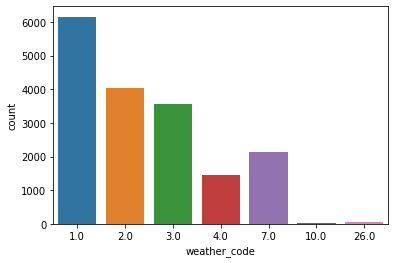

In [ ]:
sns.countplot(x="weather_code", data=data)

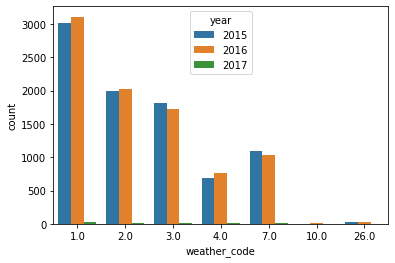

In [ ]:
sns.countplot(x="weather_code", hue = 'year', data=data)

In [ ]:
#como es de esperar los días con un tiempo más soleado se utilizan más las 
#bicicletas, como es de esperar.

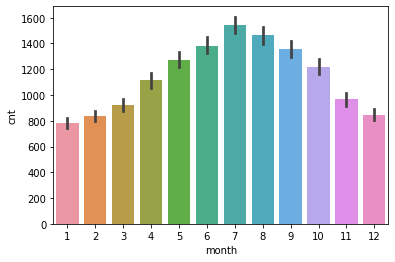

In [ ]:
sns.barplot(x="month", y="cnt", data=data) #ojo, en enero tenemos más datos, quitarlo

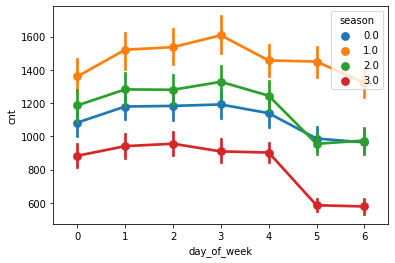

In [ ]:
sns.pointplot(data=data, x="day_of_week", y="cnt", hue="season")

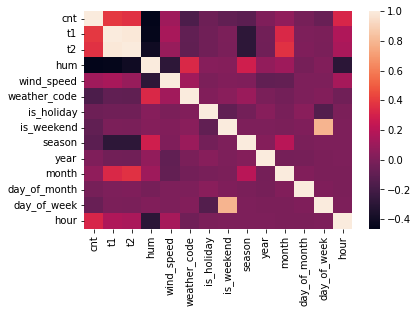

In [ ]:
sns.heatmap(data.corr())

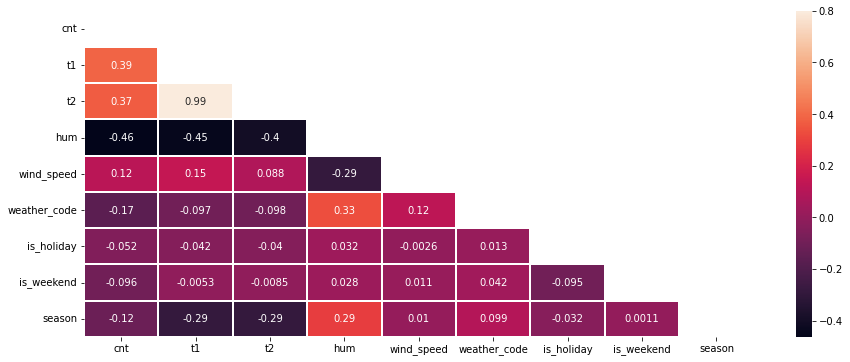

In [6]:
corrMatt = data.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=False, annot=True, ax=ax, linewidths=1);

In [ ]:
#como es normal t1 y t2 están estrechamente correlacionadas
#además "is_weekend" (fin de semana) y "day_of_week" también están 
#bastante corelacionadas, como es normal.

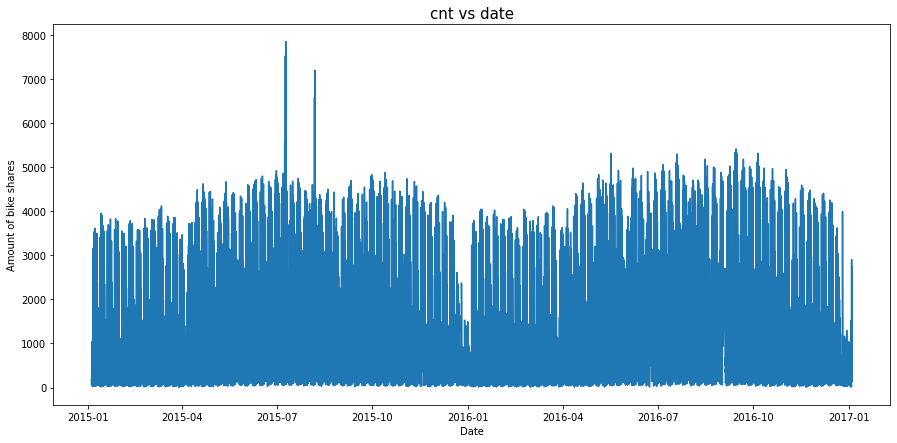

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.lineplot(data=data,x="timestamp",y="cnt")
ax.set_title("cnt vs date", fontsize=15)
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel('Amount of bike shares', fontsize=10)
plt.show()

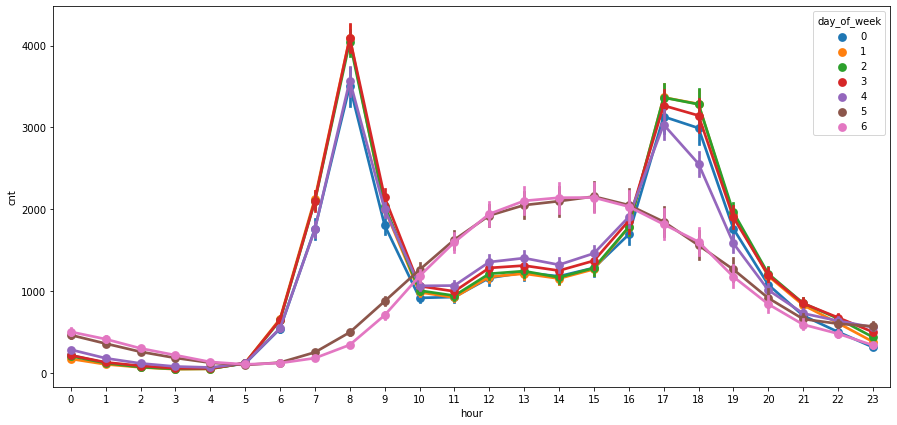

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='day_of_week', data=data)

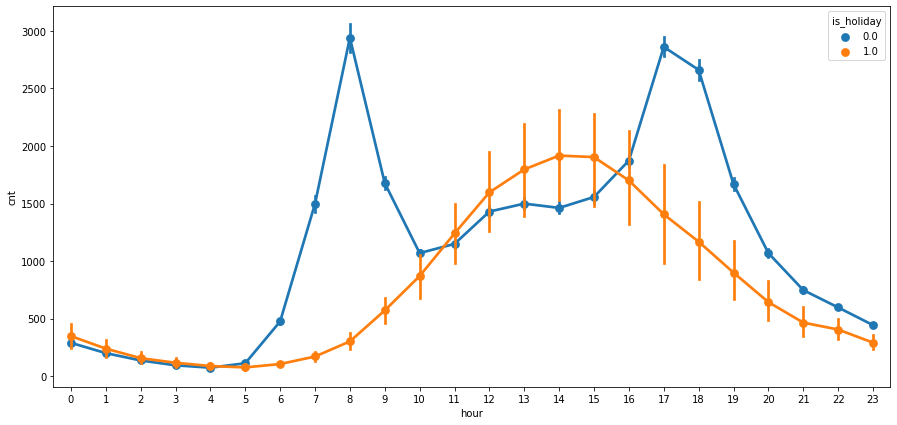

In [17]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_holiday', data=data)

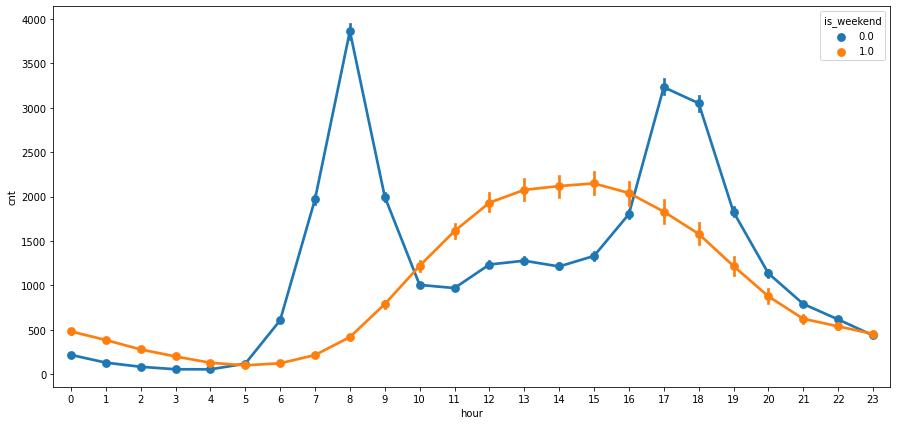

In [18]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_weekend', data=data)

In [ ]:
#vemos claramente que entre semana la gente se mueve en bicicleta con mayor frecuencia alrededor de las 8 y alrededor de las 18
#en cambio el fin de semana, se utilizan menos y además, los valores están más dispersos,
#encontrando mayor frecuencia de uso al medio dia.

In [ ]:
''''
# interpolate weather, temp, atemp, humidity, windspeed
all_df["weather"] = all_df["weather"].interpolate(method='time').apply(np.round)
all_df["temp"] = all_df["temp"].interpolate(method='time')
all_df["atemp"] = all_df["atemp"].interpolate(method='time')
all_df["humidity"] = all_df["humidity"].interpolate(method='time').apply(np.round)
all_df["windspeed"] = all_df["windspeed"].interpolate(method='time')
''''

In [ ]:
# Mas preproceso 
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

preprocessing

In [22]:
data_final = data[['timestamp',
 't1',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season',
 'cnt']]

In [23]:
data_final.head()

,timestamp,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
0,2015-01-04 00:00:00,3.0,93.0,6.0,3.0,0.0,1.0,3.0,182
1,2015-01-04 01:00:00,3.0,93.0,5.0,1.0,0.0,1.0,3.0,138
2,2015-01-04 02:00:00,2.5,96.5,0.0,1.0,0.0,1.0,3.0,134
3,2015-01-04 03:00:00,2.0,100.0,0.0,1.0,0.0,1.0,3.0,72
4,2015-01-04 04:00:00,2.0,93.0,6.5,1.0,0.0,1.0,3.0,47


# quitar

In [ ]:
features

['timestamp',
 't1',
 't2',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season']

In [ ]:
######GRU


In [ ]:
data.set_index(['timestamp'], inplace=True)

KeyError: ignored

In [ ]:
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day_of_month,day_of_week,hour
timestamp,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,6,0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,4,6,2
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,4,6,3
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,6,4


In [ ]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [ ]:
target_names = ['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday']

In [ ]:
df_targets = data[target_names].shift(-shift_steps)

In [ ]:
data[target_names].head(shift_steps + 5)

,t1,t2,hum,wind_speed,weather_code,is_holiday
timestamp,,,,,,
2015-01-04 00:00:00,3.0,2.0,93.0,6.0,3.0,0.0
2015-01-04 01:00:00,3.0,2.5,93.0,5.0,1.0,0.0
2015-01-04 02:00:00,2.5,2.5,96.5,0.0,1.0,0.0
2015-01-04 03:00:00,2.0,2.0,100.0,0.0,1.0,0.0
2015-01-04 04:00:00,2.0,0.0,93.0,6.5,1.0,0.0
2015-01-04 05:00:00,2.0,2.0,93.0,4.0,1.0,0.0
2015-01-04 06:00:00,1.0,-1.0,100.0,7.0,4.0,0.0
2015-01-04 07:00:00,1.0,-1.0,100.0,7.0,4.0,0.0
2015-01-04 08:00:00,1.5,-1.0,96.5,8.0,4.0,0.0


In [ ]:
df_targets.head(5)

,t1,t2,hum,wind_speed,weather_code,is_holiday
timestamp,,,,,,
2015-01-04 00:00:00,4.0,3.0,93.0,6.0,4.0,0.0
2015-01-04 01:00:00,4.0,3.5,93.0,5.0,4.0,0.0
2015-01-04 02:00:00,5.0,4.0,87.0,6.0,4.0,0.0
2015-01-04 03:00:00,6.0,4.5,84.0,7.5,4.0,0.0
2015-01-04 04:00:00,6.5,5.0,84.0,8.0,4.0,0.0


In [ ]:
df_targets.tail()

,t1,t2,hum,wind_speed,weather_code,is_holiday
timestamp,,,,,,
2017-01-03 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
x_data = data.values[0:-shift_steps]

print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (17390, 14)


In [ ]:
y_data = df_targets.values[:-shift_steps]

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (17390, 6)


In [ ]:
train_split = 0.9
num_data = len(x_data)
num_train = int(train_split * num_data)
num_train

15651

In [ ]:
num_test = num_data - num_train
num_test

1739

In [ ]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

17390

In [ ]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

17390

In [ ]:
num_x_signals = x_data.shape[1]
num_x_signals

14

In [ ]:
num_y_signals = y_data.shape[1]
num_y_signals

6

In [ ]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -6.0
Max: 7860.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
x_scaler = MinMaxScaler()

In [ ]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [ ]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [ ]:
x_test_scaled = x_scaler.transform(x_test)

In [ ]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# train / test

In [32]:
train_split = 0.9
num_data = len(data_final)
num_train = int(train_split * num_data)
num_train

num_test = num_data - num_train
num_test

train, test = data_final.iloc[0:num_train], data_final.iloc[(num_train):len(data_final)]
print(data_final.shape, train.shape, test.shape)

(17414, 9) (15672, 9) (1742, 9)


In [35]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 'hum', 'wind_speed']

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)

test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [36]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [37]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 9) (15662,)


In [ ]:
''''
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
''''

In [ ]:
'''
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)
'''

In [ ]:
'''
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();
'''

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [ ]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();